In [1]:
from platform import python_version

print(python_version())

3.9.19


In [16]:
#!wget https://s3.amazonaws.com/tripdata/JC-202301-citibike-tripdata.csv.zip
!wget https://data.ct.gov/api/views/5mzw-sjtu/rows.csv?accessType=DOWNLOAD

--2024-04-01 23:29:18--  https://data.ct.gov/api/views/5mzw-sjtu/rows.csv?accessType=DOWNLOAD
Resolving data.ct.gov (data.ct.gov)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.ct.gov (data.ct.gov)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [     <=>            ] 113,24M  3,42MB/s    in 35s     

2024-04-01 23:29:53 (3,24 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [118737237]



In [ ]:
!unzip JC-202301-citibike-tripdata.csv.zip

In [28]:
import pandas as pd
from sqlalchemy import create_engine
import io
import os
import requests
import pymysql
import os
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
df = pd.read_csv("data/rows.csv")

/tmp/ipykernel_6622/3371070715.py:1: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/rows.csv")


In [21]:
display(df.head())

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,NaN,NaN,NaN,NaN,NaN
1,20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.5883,Residential,Single Family,NaN,NaN,NaN,NaN
2,210317,2021,07/05/2022,Avon,53 COTSWOLD WAY,329730.0,805000.0,0.4096,Residential,Single Family,NaN,NaN,NaN,POINT (-72.846365959 41.781677018)
3,200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7248,Residential,Condo,NaN,NaN,NaN,NaN
4,200243,2020,04/13/2021,Avon,111 NORTHINGTON DRIVE,619290.0,890000.0,0.6958,Residential,Single Family,NaN,NaN,NaN,NaN


In [22]:
df.dtypes

Serial Number         int64
List Year             int64
Date Recorded        object
Town                 object
Address              object
Assessed Value      float64
Sale Amount         float64
Sales Ratio         float64
Property Type        object
Residential Type     object
Non Use Code         object
Assessor Remarks     object
OPM remarks          object
Location             object
dtype: object

In [3]:
dtypes = {
    "Serial Number": int,
    "List Year": int,
    "Town": str,
    "Address": str,
    "Assessed Value": float,
    "Sale Amount": float,
    "Sales Ratio": float,
    "Property Type": str,
    "Residential Type": str,
    "Non Use Code": str,
    "Assessor Remarks": str,
    "OPM remarks": str,
    "Location": str
        }

parse_dates = ['Date Recorded']

In [4]:
print(pd.io.sql.get_schema(df, name='real_state'))

CREATE TABLE "real_state" (
"Serial Number" INTEGER,
  "List Year" INTEGER,
  "Date Recorded" TEXT,
  "Town" TEXT,
  "Address" TEXT,
  "Assessed Value" REAL,
  "Sale Amount" REAL,
  "Sales Ratio" REAL,
  "Property Type" TEXT,
  "Residential Type" TEXT,
  "Non Use Code" TEXT,
  "Assessor Remarks" TEXT,
  "OPM remarks" TEXT,
  "Location" TEXT
)


In [18]:
url = "./data/rows.csv"
df_mod = pd.read_csv(url, sep=",", dtype=dtypes, parse_dates=parse_dates)

In [19]:
len(df_mod)

1054159

In [20]:
# Convert column names to lowercase
df_mod.columns = df_mod.columns.str.lower()

# Convert column names to snake case
df_mod.columns = df_mod.columns.str.replace(' ', '_')

In [21]:
df_mod.dtypes

serial_number                int64
list_year                    int64
date_recorded       datetime64[ns]
town                        object
address                     object
assessed_value             float64
sale_amount                float64
sales_ratio                float64
property_type               object
residential_type            object
non_use_code                object
assessor_remarks            object
opm_remarks                 object
location                    object
dtype: object

In [22]:
df_mod = df_mod.loc[:, ~df_mod.columns.isin(['serial_number','location','opm_remarks', 'assessor_remarks', 'non_use_code'])]

In [23]:
df_mod.dtypes

list_year                    int64
date_recorded       datetime64[ns]
town                        object
address                     object
assessed_value             float64
sale_amount                float64
sales_ratio                float64
property_type               object
residential_type            object
dtype: object

In [24]:
df_mod.describe()

,list_year,date_recorded,assessed_value,sale_amount,sales_ratio
count,1.054159e+06,1054157,1.054159e+06,1.054159e+06,1.054159e+06
mean,2.010774e+03,2012-01-18 05:11:54.452591360,2.797416e+05,3.990286e+05,9.953241e+00
min,2.001000e+03,1999-04-05 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.004000e+03,2005-09-16 00:00:00,8.845000e+04,1.422000e+05,4.816008e-01
50%,2.011000e+03,2011-12-02 00:00:00,1.395800e+05,2.300000e+05,6.162887e-01
75%,2.017000e+03,2018-02-14 00:00:00,2.270000e+05,3.700000e+05,7.764000e-01
max,2.021000e+03,2022-09-30 00:00:00,8.815100e+08,5.000000e+09,1.226420e+06
std,6.540711e+00,NaN,1.650117e+06,5.229758e+06,1.838434e+03


In [25]:
df_mod.isnull().sum()

list_year                0
date_recorded            2
town                     0
address                 51
assessed_value           0
sale_amount              0
sales_ratio              0
property_type       382446
residential_type    393884
dtype: int64

In [64]:
select_value = 'Vacant Land'
result = df_mod[df_mod['property_type'] == select_value]

print(result.tail())

        list_year date_recorded        town                 address  \
123778       2021    2022-09-28   Waterford       15 NEW SHORE ROAD   
123829       2021    2021-12-07    Westport       LYONS PLAINS ROAD   
123849       2021    2022-02-04  Winchester  173 DANBURY QUARTER RD   
123867       2021    2022-01-27      Weston      50 BUTTONBALL LANE   
123896       2021    2022-05-06    Woodbury      69 BACON POND ROAD   

        assessed_value  sale_amount  sales_ratio property_type  \
123778        103960.0     275000.0     0.378000   Vacant Land   
123829         32700.0      25000.0     1.308000   Vacant Land   
123849         40600.0      47500.0     0.854737   Vacant Land   
123867        365720.0     625000.0     0.585100   Vacant Land   
123896         79590.0     360000.0     0.221000   Vacant Land   

       residential_type  
123778              NaN  
123829              NaN  
123849              NaN  
123867              NaN  
123896              NaN  


In [67]:
distinct_values = df_mod['property_type'].unique()
display(distinct_values)

array(['Commercial', 'Residential', 'Vacant Land', nan, 'Apartments',
       'Industrial', 'Public Utility', 'Condo', 'Two Family',
       'Three Family', 'Single Family', 'Four Family'], dtype=object)

In [68]:
distinct_values = df_mod['list_year'].unique()
display(distinct_values)

array([2020, 2021, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [103]:
df_grp = df_mod.where(df_mod['list_year'] == 2021)
df_grp = df_grp.dropna()

        list_year date_recorded          town                    address  \
2          2021.0    2022-07-05          Avon            53 COTSWOLD WAY   
10         2021.0    2022-04-29     Bethlehem          89 LONG MEADOW RD   
11         2021.0    2021-12-20    Bloomfield             43 LEDYARD AVE   
16         2021.0    2021-10-20      Branford          25 QUARRY DOCK RD   
17         2021.0    2022-01-14    Bridgeport         360 VINCELLETTE ST   
...           ...           ...           ...                        ...   
123892     2021.0    2022-03-22      Westport            140 EASTON ROAD   
123893     2021.0    2022-08-03  Wethersfield              181 FOREST DR   
123894     2021.0    2021-11-16     Watertown            50 SUMMIT RIDGE   
123895     2021.0    2022-09-20      Woodbury  89 TAMARACK LANR UNIT 89A   
123897     2021.0    2022-06-29    West Haven             114 TUTHILL ST   

        assessed_value  sale_amount  sales_ratio property_type  \
2             329730.

In [105]:
df_grp1 = df_grp.groupby(['list_year', 'town'])[['assessed_value', 'sale_amount']].mean()
print(df_grp1)

                         assessed_value    sale_amount
list_year town                                        
2021.0    Ansonia         129553.086420  291105.740741
          Avon            266762.389381  487133.567677
          Barkhamsted     163332.631579  323568.807018
          Berlin          187557.385507  339661.730435
          Bethany         220897.058824  458987.635294
...                                 ...            ...
          Windsor         133124.053422  267701.218698
          Windsor Locks   116437.722846  230289.973783
          Wolcott         180046.792208  299032.737013
          Woodbridge      272355.243902  569913.920732
          Woodbury        199898.086124  436931.559809

[140 rows x 2 columns]


<Axes: xlabel='list_year,town'>

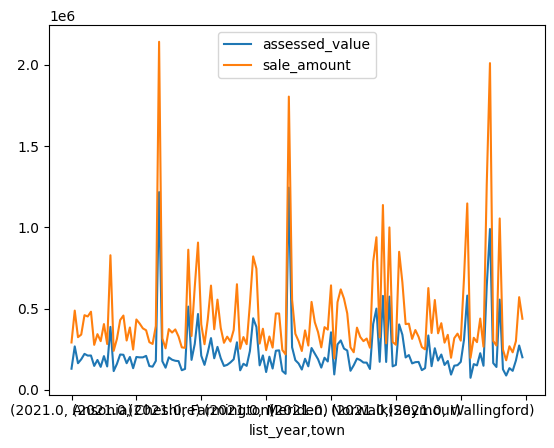

In [106]:
df_grp1.plot()

In [26]:
df_mod.dtypes

list_year                    int64
date_recorded       datetime64[ns]
town                        object
address                     object
assessed_value             float64
sale_amount                float64
sales_ratio                float64
property_type               object
residential_type            object
dtype: object

In [29]:
table = pa.Table.from_pandas(df_mod)

In [30]:
# Define the Parquet file path
parquet_path = './data/parquet/'

In [31]:
# Write partitioned Parquet file
pq.write_to_dataset(table, root_path=parquet_path, partition_cols=['list_year'])
